In [1]:
import os, sys, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import microgrid_sim.components.generators as gens
import microgrid_sim.components.loads as loads
import microgrid_sim.components.storage as storage
import microgrid_sim.core.environment as core_env
import microgrid_sim.utils.plotting as plotting

importlib.reload(gens)
importlib.reload(loads)
importlib.reload(storage)
importlib.reload(core_env)
importlib.reload(plotting)

from microgrid_sim.components.generators import (
    PVGenerator, WindTurbine, HydroGenerator, FossilGenerator, GridIntertie
)
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.core import MicrogridEnv
from microgrid_sim.utils import plot_simulation

print("Imports OK.")


Imports OK.


In [2]:
steps = 24            # simulate 24 steps (1 day)
dt_min = 60           # 60-minute step size
t = np.arange(steps)

# PV irradiance profile (W/m^2): a simple "day curve"
irradiance = np.clip(1000 * np.sin((t - 6) / 24 * 2 * np.pi), 0, None)

# Wind speed (m/s): a gentle daily variation
wind_speed = 6.0 + 2.0 * np.sin(t/24 * 2*np.pi + 1.0)

# Residential load (kW): mild evening peak
res_load = 1.0 + 0.5 * np.sin((t - 3)/24 * 2*np.pi)

# Factory load (kW): base + small spikes every 6 hours
fac_load = 3.0 + 1.0 * (t % 6 == 0).astype(float)

profiles = pd.DataFrame({
    "t": t,
    "irradiance_Wm2": irradiance,
    "wind_speed_ms": wind_speed,
    "residential_kw": res_load,
    "factory_kw": fac_load
})
profiles.head()


,t,irradiance_Wm2,wind_speed_ms,residential_kw,factory_kw
0,0,0.0,7.682942,0.646447,4.0
1,1,0.0,7.905278,0.750000,3.0
2,2,0.0,7.997773,0.870590,3.0
3,3,0.0,7.954123,1.000000,3.0
4,4,0.0,7.777302,1.129410,3.0


In [3]:
pv = PVGenerator("pv", capacity_kw=5.0, time_step_minutes=dt_min, derate=0.9)
wind = WindTurbine("wind", rated_kw=3.5, time_step_minutes=dt_min, cut_in_ms=3, rated_ms=12, cut_out_ms=25)

# Dispatchable fossil gen with linear fuel cost
fossil = FossilGenerator("diesel", p_min_kw=0.0, p_max_kw=15.0, time_step_minutes=dt_min, fuel_cost_per_kwh=0.25)

# Loads (profile-driven)
house = ResidentialLoad("house", base_kw=float(np.mean(res_load)), noise_std=0.0)
factory = FactoryLoad("factory", base_kw=float(np.mean(fac_load)), noise_std=0.0)

# Battery (from Topic 1)
battery = BatteryStorage(
    "bat", capacity_kwh=4.0, time_step_minutes=dt_min,
    initial_soc=0.5, min_soc=0.1, max_soc=0.9,
    max_charge_kw=10.0, max_discharge_kw=10.0,
    charge_efficiency=0.95, discharge_efficiency=0.95,
    degradation_cost_per_kwh=0.01
)

# Grid with buy/sell tariffs and limits
# Example limits: can import up to 12 kW, export up to 8 kW
grid = GridIntertie("grid", time_step_minutes=dt_min,
                    price_import_per_kwh=0.20, price_export_per_kwh=0.05,
                    import_limit_kw=12.0, export_limit_kw=8.0)

print("Components ready.")


Components ready.


In [4]:
env = MicrogridEnv(simulation_steps=steps)
env.add_component(pv)
env.add_component(wind)
env.add_component(fossil)
env.add_component(house)
env.add_component(factory)
env.add_component(battery)
env.add_component(grid, is_grid=True)
env.reset()

print("Environment ready.")


Environment ready.


In [5]:
actions_list, exog_list = [], []

for k in range(steps):
    hour = k % 24

    # Simple heuristic controls:
    # Diesel: 5 kW at night, off during the day
    diesel_setpoint = 3.0 if (0 <= hour < 7 or 20 <= hour < 24) else 0.0

    # - Battery: charge around noon, discharge in the evening
    if 11 <= hour <= 14:
        bat_setpoint = -8.0   # charge
    elif 18 <= hour <= 21:
        bat_setpoint = +8.0   # discharge
    else:
        bat_setpoint = 0.0

    actions = {
        "diesel": diesel_setpoint,
        "bat": {"set_state": "ON", "power_setpoint": bat_setpoint},
        "grid": {"set_state": "ON"}
    }
    exo = {
        "pv": {"irradiance_Wm2": float(irradiance[k])},
        "wind": {"wind_speed_ms": float(wind_speed[k])},
        "house": {"load_kw": float(res_load[k])},
        "factory": {"load_kw": float(fac_load[k])},
    }
    actions_list.append(actions)
    exog_list.append(exo)

print("Prepared actions and exogenous inputs.")


Prepared actions and exogenous inputs.


In [6]:
# --- Cell 6: run & results
env.run(actions_list, exogenous_list=exog_list)
df = env.get_results(as_dataframe=True)

print("First rows:")
display(df.head())

print("\nSummary of net power before grid:")
display(df[["net_power_unbalanced"]].describe())

total_cf = df["total_cashflow"].sum() if "total_cashflow" in df.columns else float('nan')
downtime_steps = int(df["downtime"].sum()) if "downtime" in df.columns else 0
unmet_energy = df["cum_unmet_energy_kwh"].iloc[-1] if "cum_unmet_energy_kwh" in df.columns else 0.0
curtailed_energy = df["cum_curtailed_energy_kwh"].iloc[-1] if "cum_curtailed_energy_kwh" in df.columns else 0.0

print(f"\nTotals over {steps} steps:")
print(f"  Total cash flow (NEG=expense, POS=revenue): {total_cf:+.3f}")
print(f"  Downtime steps: {downtime_steps}")
print(f"  Total unmet energy (kWh): {unmet_energy:.3f}")
print(f"  Total curtailed energy (kWh): {curtailed_energy:.3f}")


First rows:


,pv_power,pv_cost,wind_power,wind_cost,diesel_power,diesel_cost,grid_power,grid_cost,bat_power,bat_cost,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.493057,0.0,3.0,-0.75,1.153390,-0.230678,0.0,-0.0,...,3.493057,-4.646447,0.0,1.153390,-1.153390,0.0,0.0,0.0,-0.980678,0.0
1,0.0,0.0,0.566672,0.0,3.0,-0.75,0.183328,-0.036666,0.0,-0.0,...,3.566672,-3.750000,0.0,0.183328,-0.183328,0.0,0.0,0.0,-0.786666,1.0
2,0.0,0.0,0.599336,0.0,3.0,-0.75,0.271255,-0.054251,0.0,-0.0,...,3.599336,-3.870590,0.0,0.271255,-0.271255,0.0,0.0,0.0,-0.804251,2.0
3,0.0,0.0,0.583769,0.0,3.0,-0.75,0.416231,-0.083246,0.0,-0.0,...,3.583769,-4.000000,0.0,0.416231,-0.416231,0.0,0.0,0.0,-0.833246,3.0
4,0.0,0.0,0.523466,0.0,3.0,-0.75,0.605943,-0.121189,0.0,-0.0,...,3.523466,-4.129410,0.0,0.605943,-0.605943,0.0,0.0,0.0,-0.871189,4.0



Summary of net power before grid:


,net_power_unbalanced
count,24.000000
mean,-1.094922
std,0.982246
min,-3.501295
25%,-1.646068
50%,-0.815509
75%,-0.298026
max,0.102965



Totals over 24 steps:
  Total cash flow (NEG=expense, POS=revenue): -13.568
  Downtime steps: 0
  Total unmet energy (kWh): 0.000
  Total curtailed energy (kWh): 0.000


{'fig': <Figure size 1400x2400 with 8 Axes>,
 'axes': [<Axes: title={'center': 'Generation Power (kW) — positive portions only'}, ylabel='kW'>,
  <Axes: title={'center': 'Consumption Power (kW) — negative portions & grid imports'}, ylabel='kW'>,
  <Axes: title={'center': 'Net vs Grid (kW)'}, ylabel='kW'>,
  <Axes: title={'center': 'State of Charge (SOC)'}, ylabel='SOC (0–1)'>,
  <Axes: title={'center': 'Per-Step Cash Flow (NEG=expense, POS=revenue)'}, ylabel='$ / step'>,
  <Axes: title={'center': 'Cumulative Total Cash Flow'}, ylabel='$'>,
  <Axes: title={'center': 'Security of Supply'}, ylabel='kW (and 0/1)'>,
  <Axes: title={'center': 'Actions by Component'}, xlabel='Step', ylabel='Setpoint'>],
 'out_dir': None}

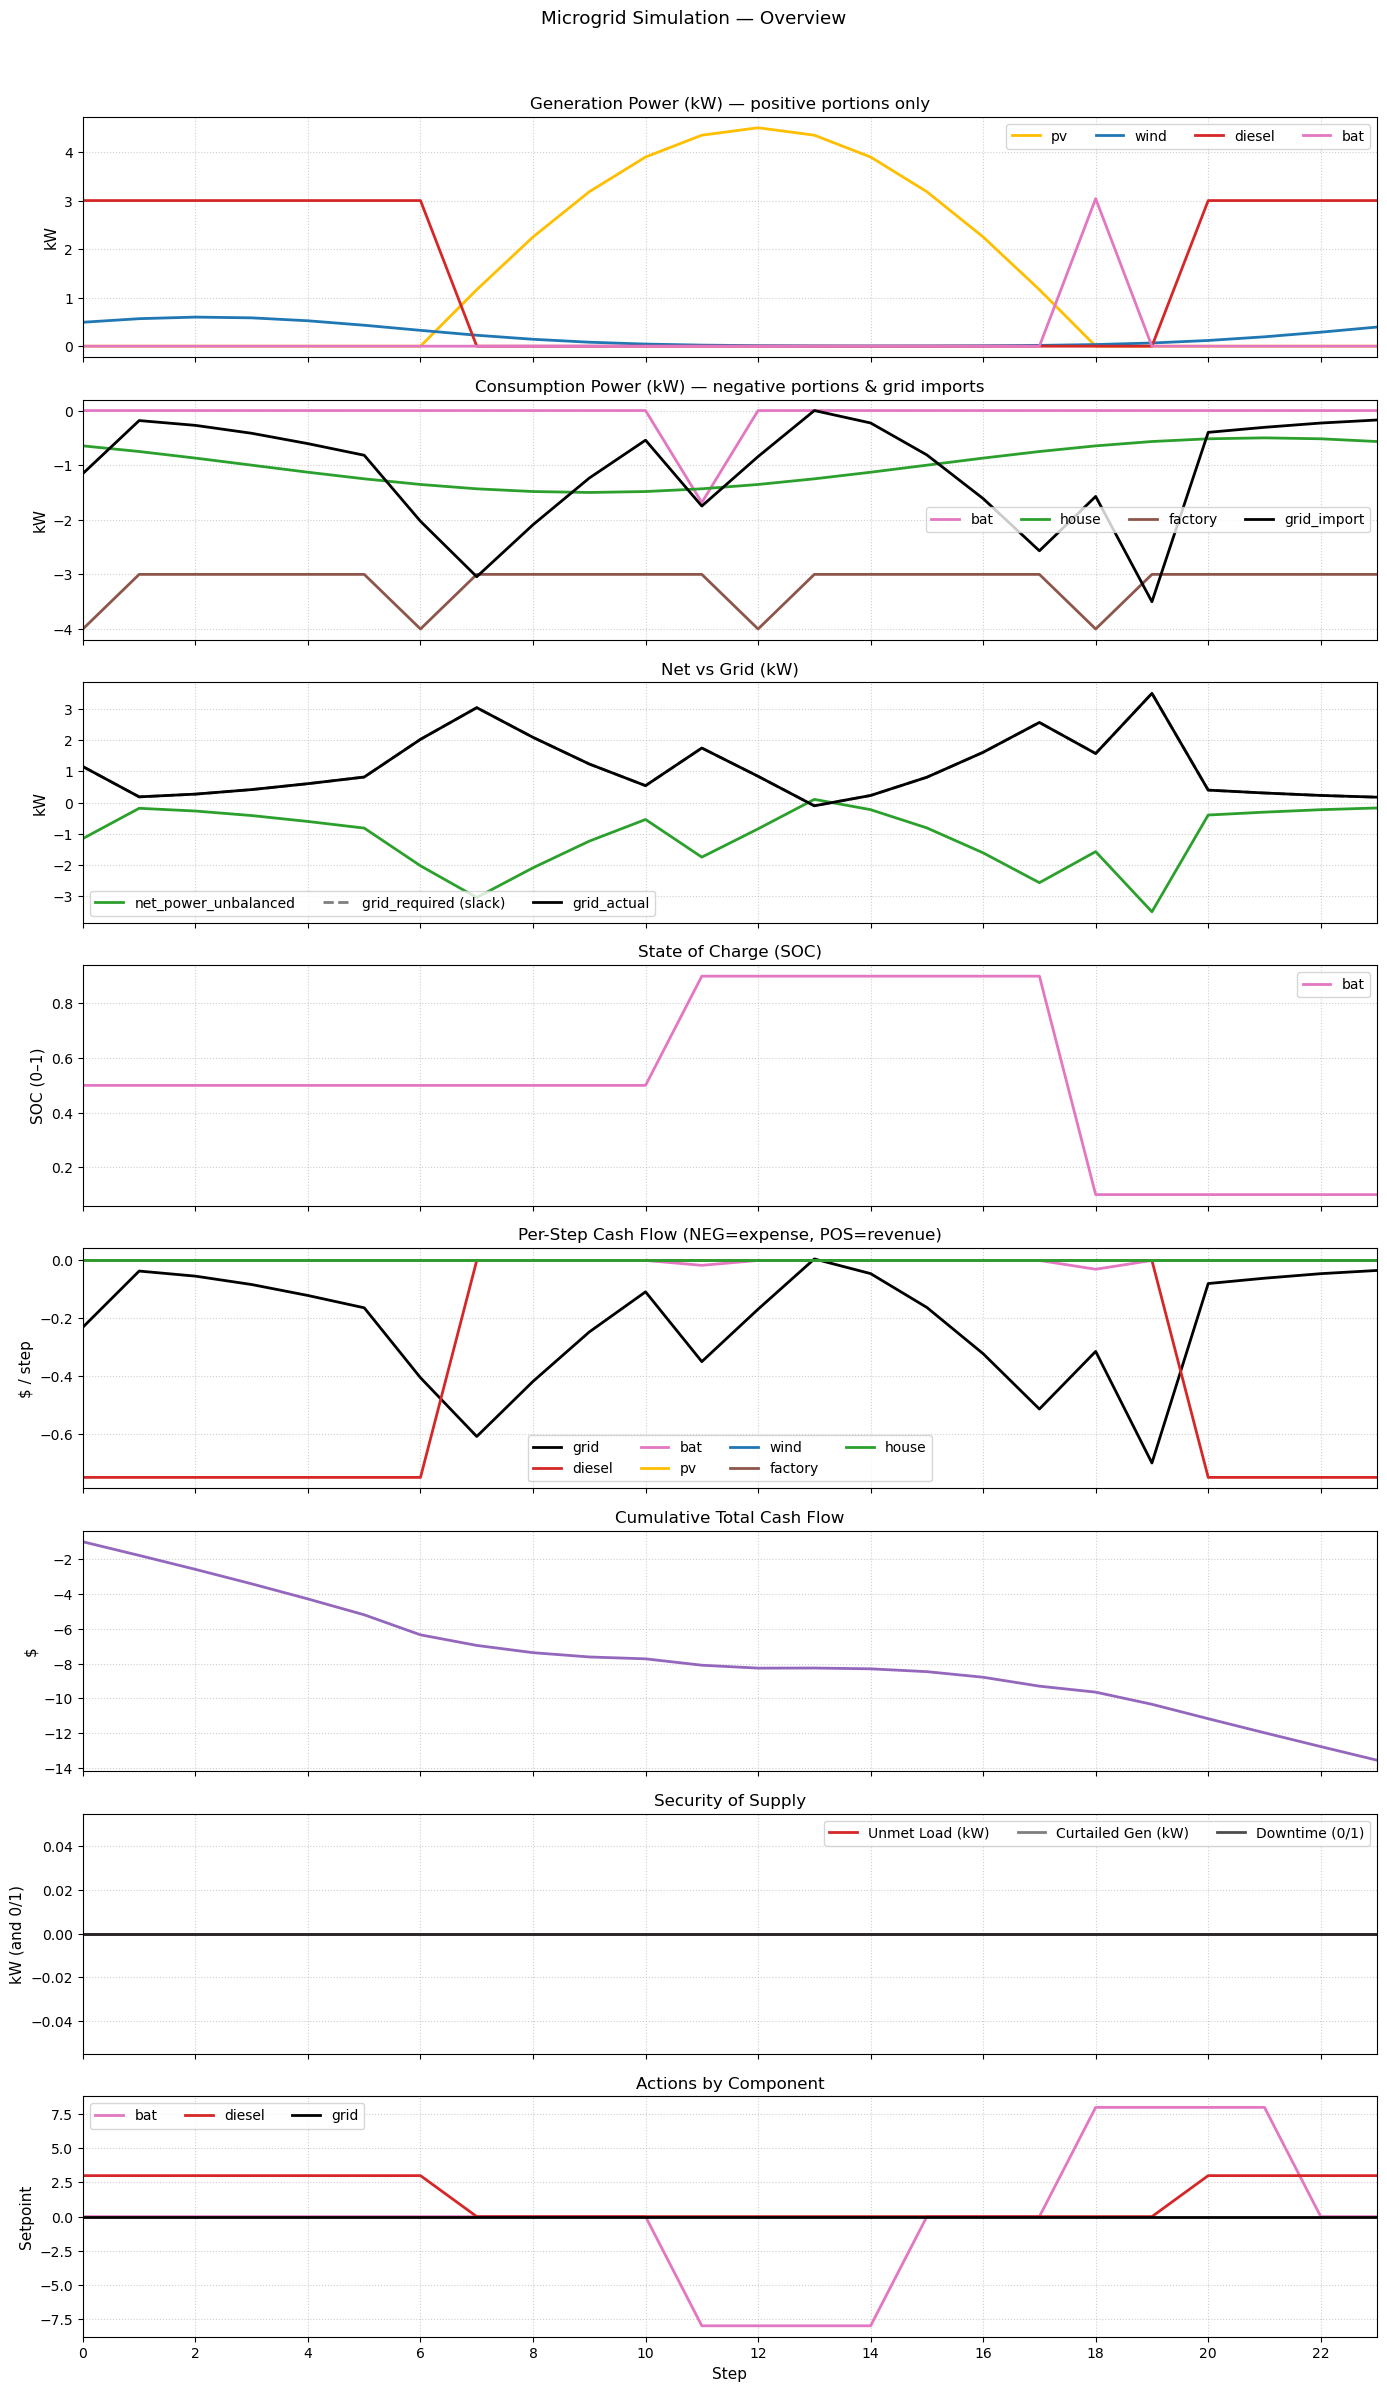

In [7]:
# --- Cell 7: standard plots
plot_simulation(df, actions=actions_list, xlim_auto=True)


Stress test results:
  Downtime steps: 5
  Total unmet energy (kWh): 3.231
  Total curtailed energy (kWh): 0.000


{'fig': <Figure size 1400x2400 with 8 Axes>,
 'axes': [<Axes: title={'center': 'Generation Power (kW) — positive portions only'}, ylabel='kW'>,
  <Axes: title={'center': 'Consumption Power (kW) — negative portions & grid imports'}, ylabel='kW'>,
  <Axes: title={'center': 'Net vs Grid (kW)'}, ylabel='kW'>,
  <Axes: title={'center': 'State of Charge (SOC)'}, ylabel='SOC (0–1)'>,
  <Axes: title={'center': 'Per-Step Cash Flow (NEG=expense, POS=revenue)'}, ylabel='$ / step'>,
  <Axes: title={'center': 'Cumulative Total Cash Flow'}, ylabel='$'>,
  <Axes: title={'center': 'Security of Supply'}, ylabel='kW (and 0/1)'>,
  <Axes: title={'center': 'Actions by Component'}, xlabel='Step', ylabel='Setpoint'>],
 'out_dir': 'plots\\Test'}

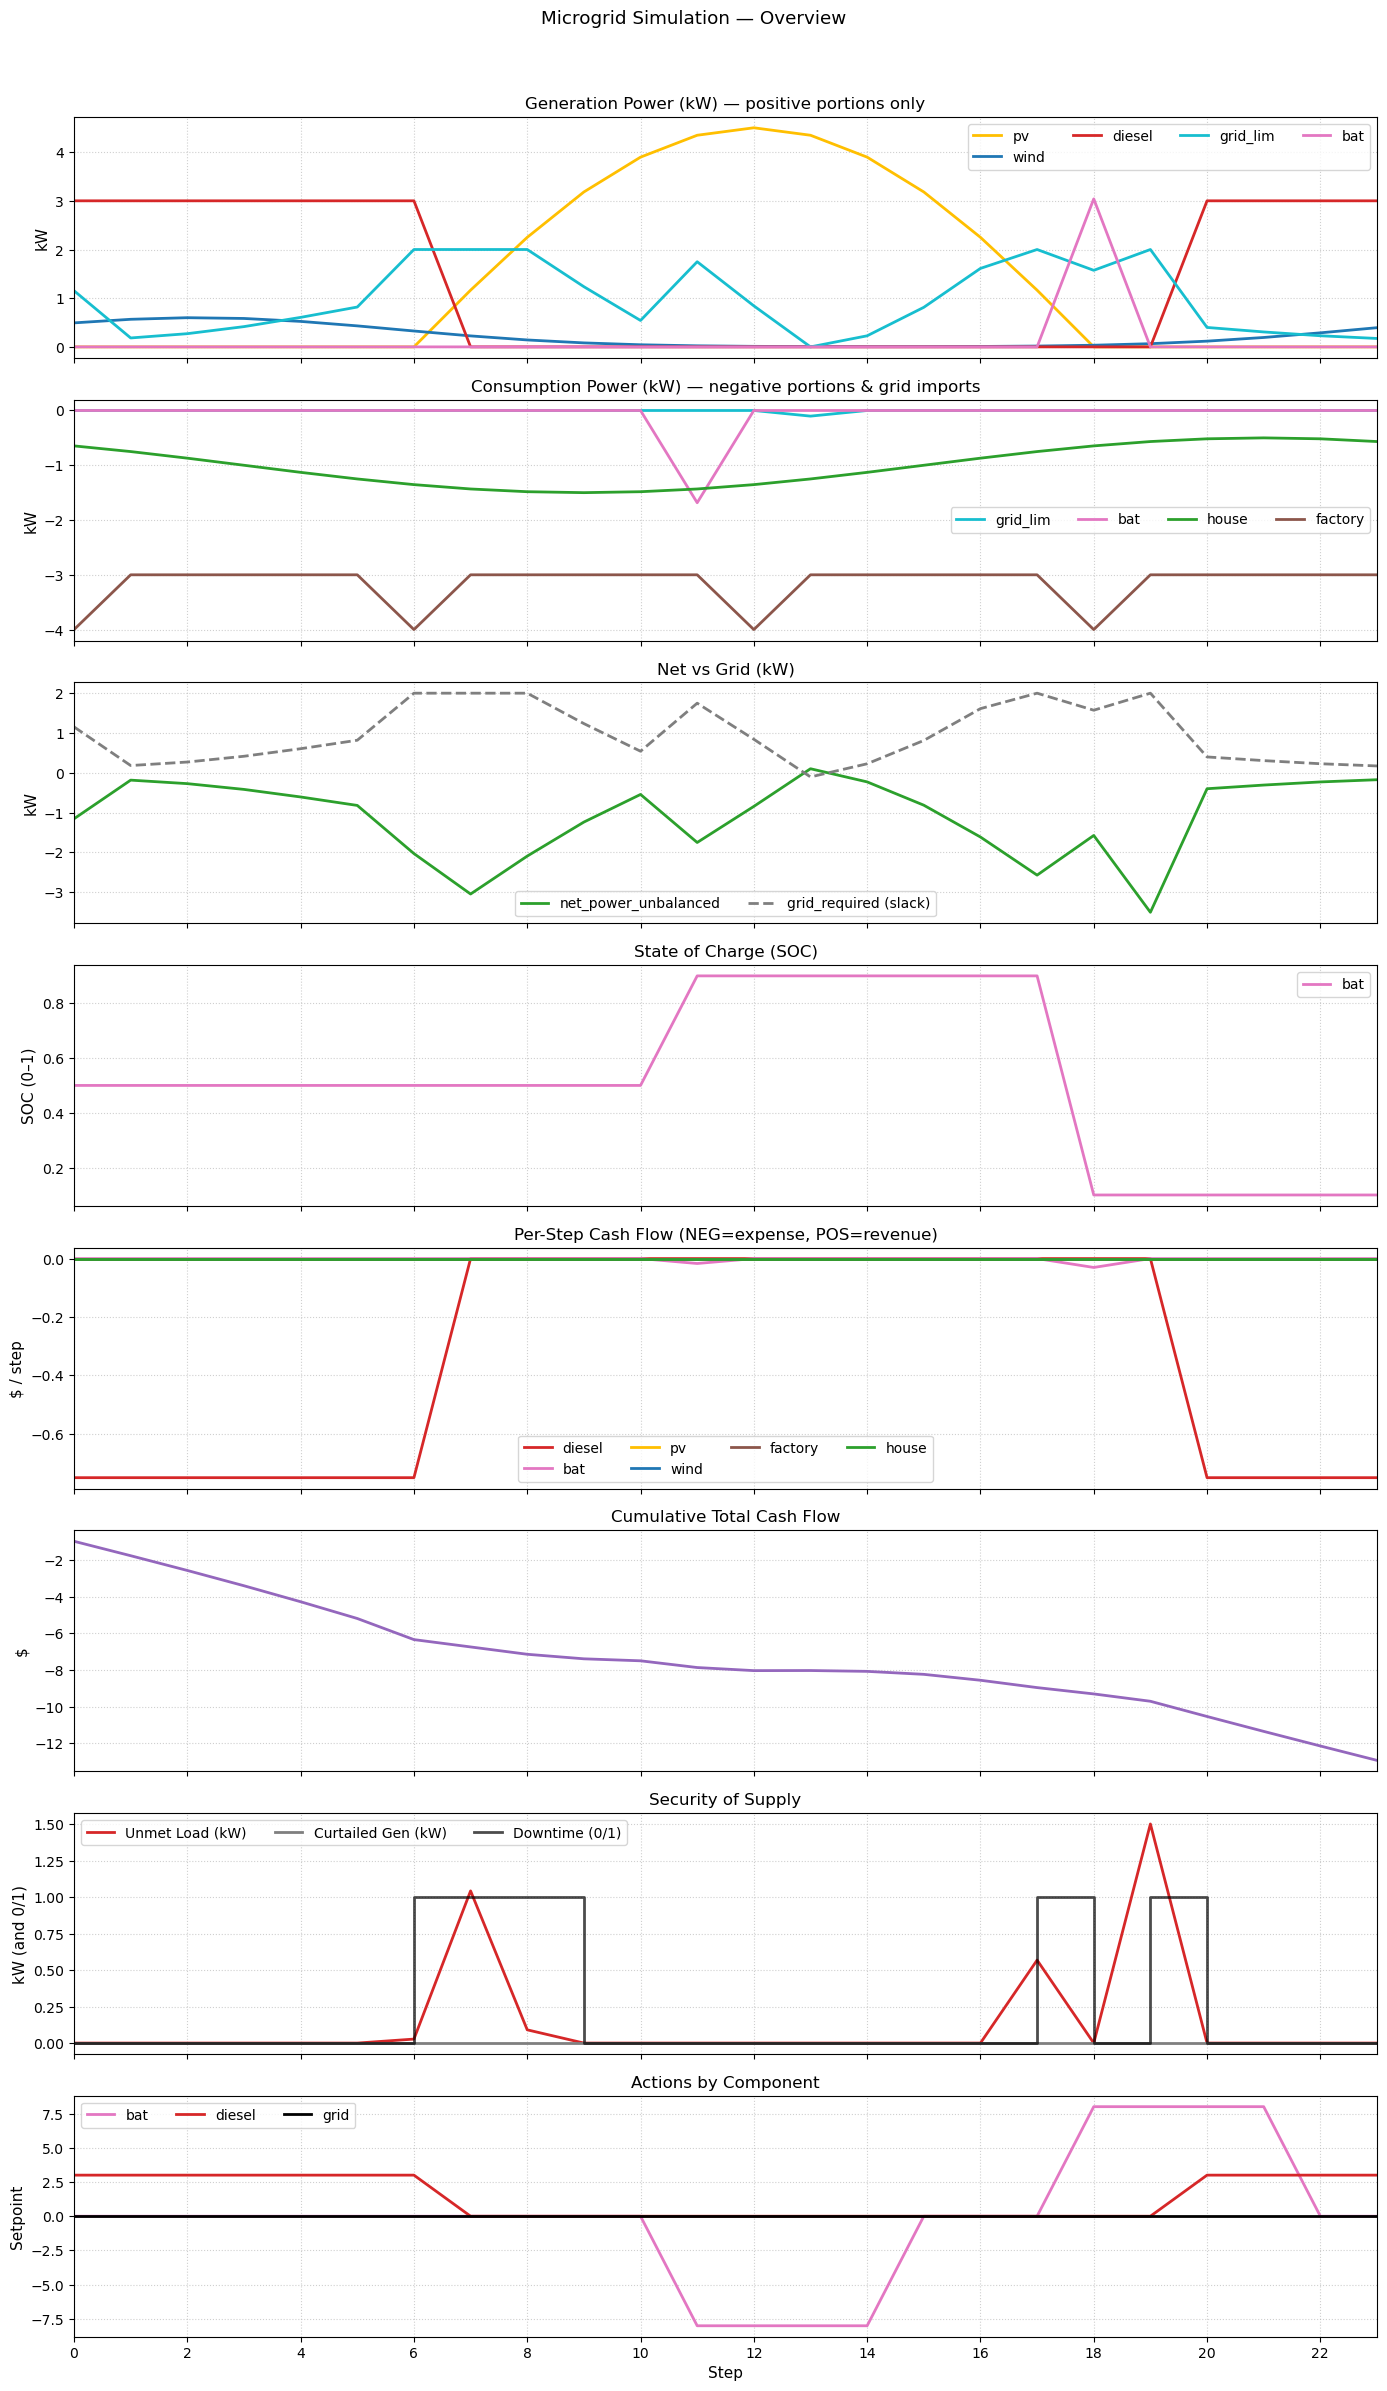

In [8]:
grid_limited = GridIntertie("grid_lim", time_step_minutes=dt_min,
                            price_import_per_kwh=0.20, price_export_per_kwh=0.05,
                            import_limit_kw=2.0, export_limit_kw=4.0)

env2 = MicrogridEnv(simulation_steps=steps)
env2.add_component(pv)
env2.add_component(wind)
env2.add_component(fossil)
env2.add_component(house)
env2.add_component(factory)
env2.add_component(battery)
env2.add_component(grid_limited, is_grid=True)
env2.run(actions_list, exogenous_list=exog_list)
df2 = env2.get_results(as_dataframe=True)

dt_hours = dt_min / 60.0

print("Stress test results:")
print(f"  Downtime steps: {int(df2['downtime'].sum())}")
print(f"  Total unmet energy (kWh): {df2['unmet_load_kw'].sum() * dt_hours:.3f}")
print(f"  Total curtailed energy (kWh): {df2['curtailed_gen_kw'].sum() * dt_hours:.3f}")
plot_simulation(df2, actions=actions_list, save=True, sim_name="Test")


## Using the Data Builder

{'fig': <Figure size 1400x2400 with 8 Axes>,
 'axes': [<Axes: title={'center': 'Generation Power (kW) — positive portions only'}, ylabel='kW'>,
  <Axes: title={'center': 'Consumption Power (kW) — negative portions & grid imports'}, ylabel='kW'>,
  <Axes: title={'center': 'Net vs Grid (kW)'}, ylabel='kW'>,
  <Axes: title={'center': 'State of Charge (SOC)'}, ylabel='SOC (0–1)'>,
  <Axes: title={'center': 'Per-Step Cash Flow (NEG=expense, POS=revenue)'}, ylabel='$ / step'>,
  <Axes: title={'center': 'Cumulative Total Cash Flow'}, ylabel='$'>,
  <Axes: title={'center': 'Security of Supply'}, ylabel='kW (and 0/1)'>,
  <Axes: title={'center': 'Actions by Component'}, xlabel='Step', ylabel='Setpoint'>],
 'out_dir': None}

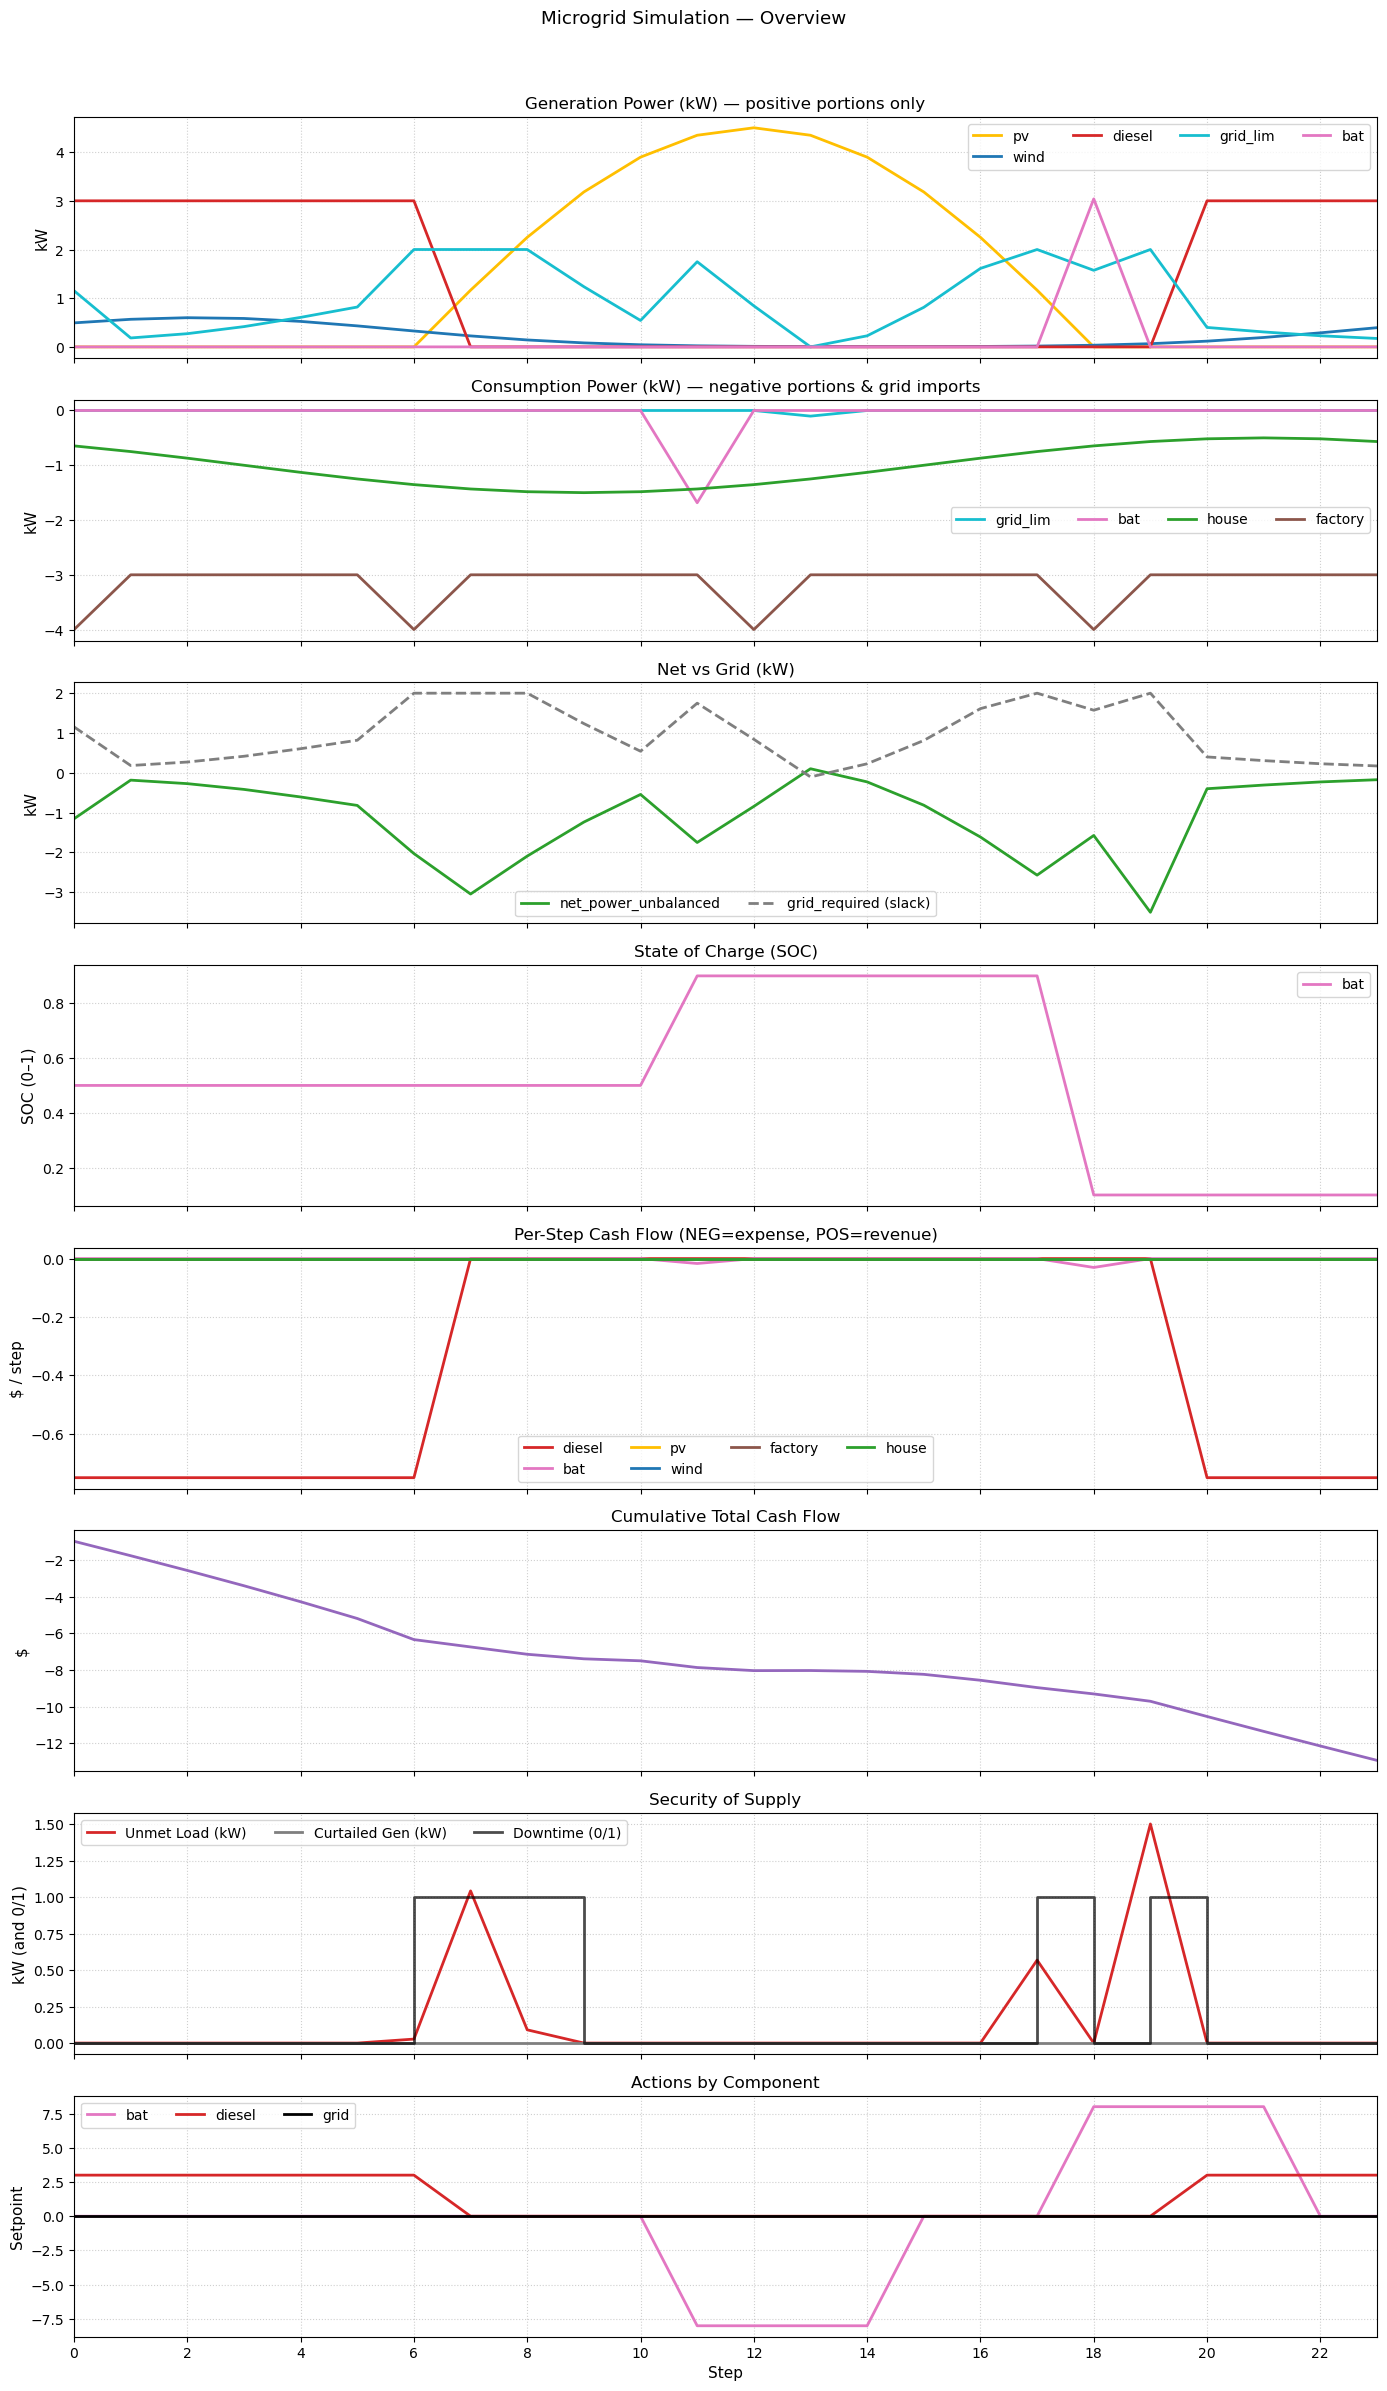

In [9]:
from microgrid_sim.utils import DataSeries, ExogenousSpec, ExogenousBuilder

steps   = 24     # or len of your horizon
start_i = 0

# --- Option A: quick synthetic (using arrays you already created) ---
ghi_ds    = DataSeries.from_array(irradiance, name="ghi_Wm2")
wind_ds   = DataSeries.from_array(wind_speed, name="wind_ms")
house_ds  = DataSeries.from_array(res_load,  name="kW")
factory_ds= DataSeries.from_array(fac_load,  name="kW")

# --- Option B: CSVs (make sure each CSV has at least 'value' col you pick) ---
# ghi_ds    = DataSeries.from_csv("data/solar_irradiance.csv", time_col="timestamp", value_col="ghi_Wm2")
# wind_ds   = DataSeries.from_csv("data/wind_speed.csv",     time_col="timestamp", value_col="wind_ms")
# house_ds  = DataSeries.from_csv("data/residential_load.csv", time_col="timestamp", value_col="kW")
# factory_ds= DataSeries.from_csv("data/factory_load.csv",     time_col="timestamp", value_col="kW")

spec = ExogenousSpec({
    "pv":      {"irradiance_Wm2": ghi_ds},
    "wind":    {"wind_speed_ms" : wind_ds},
    "house":   {"load_kw"       : house_ds},
    "factory": {"load_kw"       : factory_ds},
})

exog_builder = ExogenousBuilder(spec)
exog_list = exog_builder.build(steps=steps, start_index=start_i)

# now run the env with your actions_list and this exog_list
env.run(actions_list, exogenous_list=exog_list)
df = env.get_results()
plot_simulation(df2, actions=actions_list)


## Dynamically controlling the grid

In [10]:
island_start = 10
island_end   = 15

In [11]:
# build env as usual
env = MicrogridEnv(simulation_steps=steps)
env.add_component(pv)
env.add_component(wind)
env.add_component(fossil)
env.add_component(house)
env.add_component(factory)
env.add_component(battery)
env.add_component(grid, is_grid=True)
env.reset()

# run step by step to control grid connection dynamically
for k in range(steps):
    # exogenous for this step
    exo = exog_list[k]
    act = actions_list[k]

    # 👇 dynamically control the grid connection
    if island_start <= k < island_end:
        grid.disconnect()    # microgrid goes islanded
    else:
        grid.connect()       # reconnected to main grid

    # advance one step
    env.step(actions=act, exogenous=exo)

df = env.get_results()


{'fig': <Figure size 1400x2400 with 8 Axes>,
 'axes': [<Axes: title={'center': 'Generation Power (kW) — positive portions only'}, ylabel='kW'>,
  <Axes: title={'center': 'Consumption Power (kW) — negative portions & grid imports'}, ylabel='kW'>,
  <Axes: title={'center': 'Net vs Grid (kW)'}, ylabel='kW'>,
  <Axes: title={'center': 'State of Charge (SOC)'}, ylabel='SOC (0–1)'>,
  <Axes: title={'center': 'Per-Step Cash Flow (NEG=expense, POS=revenue)'}, ylabel='$ / step'>,
  <Axes: title={'center': 'Cumulative Total Cash Flow'}, ylabel='$'>,
  <Axes: title={'center': 'Security of Supply'}, ylabel='kW (and 0/1)'>,
  <Axes: title={'center': 'Actions by Component'}, xlabel='Step', ylabel='Setpoint'>],
 'out_dir': 'plots\\grid_island_test'}

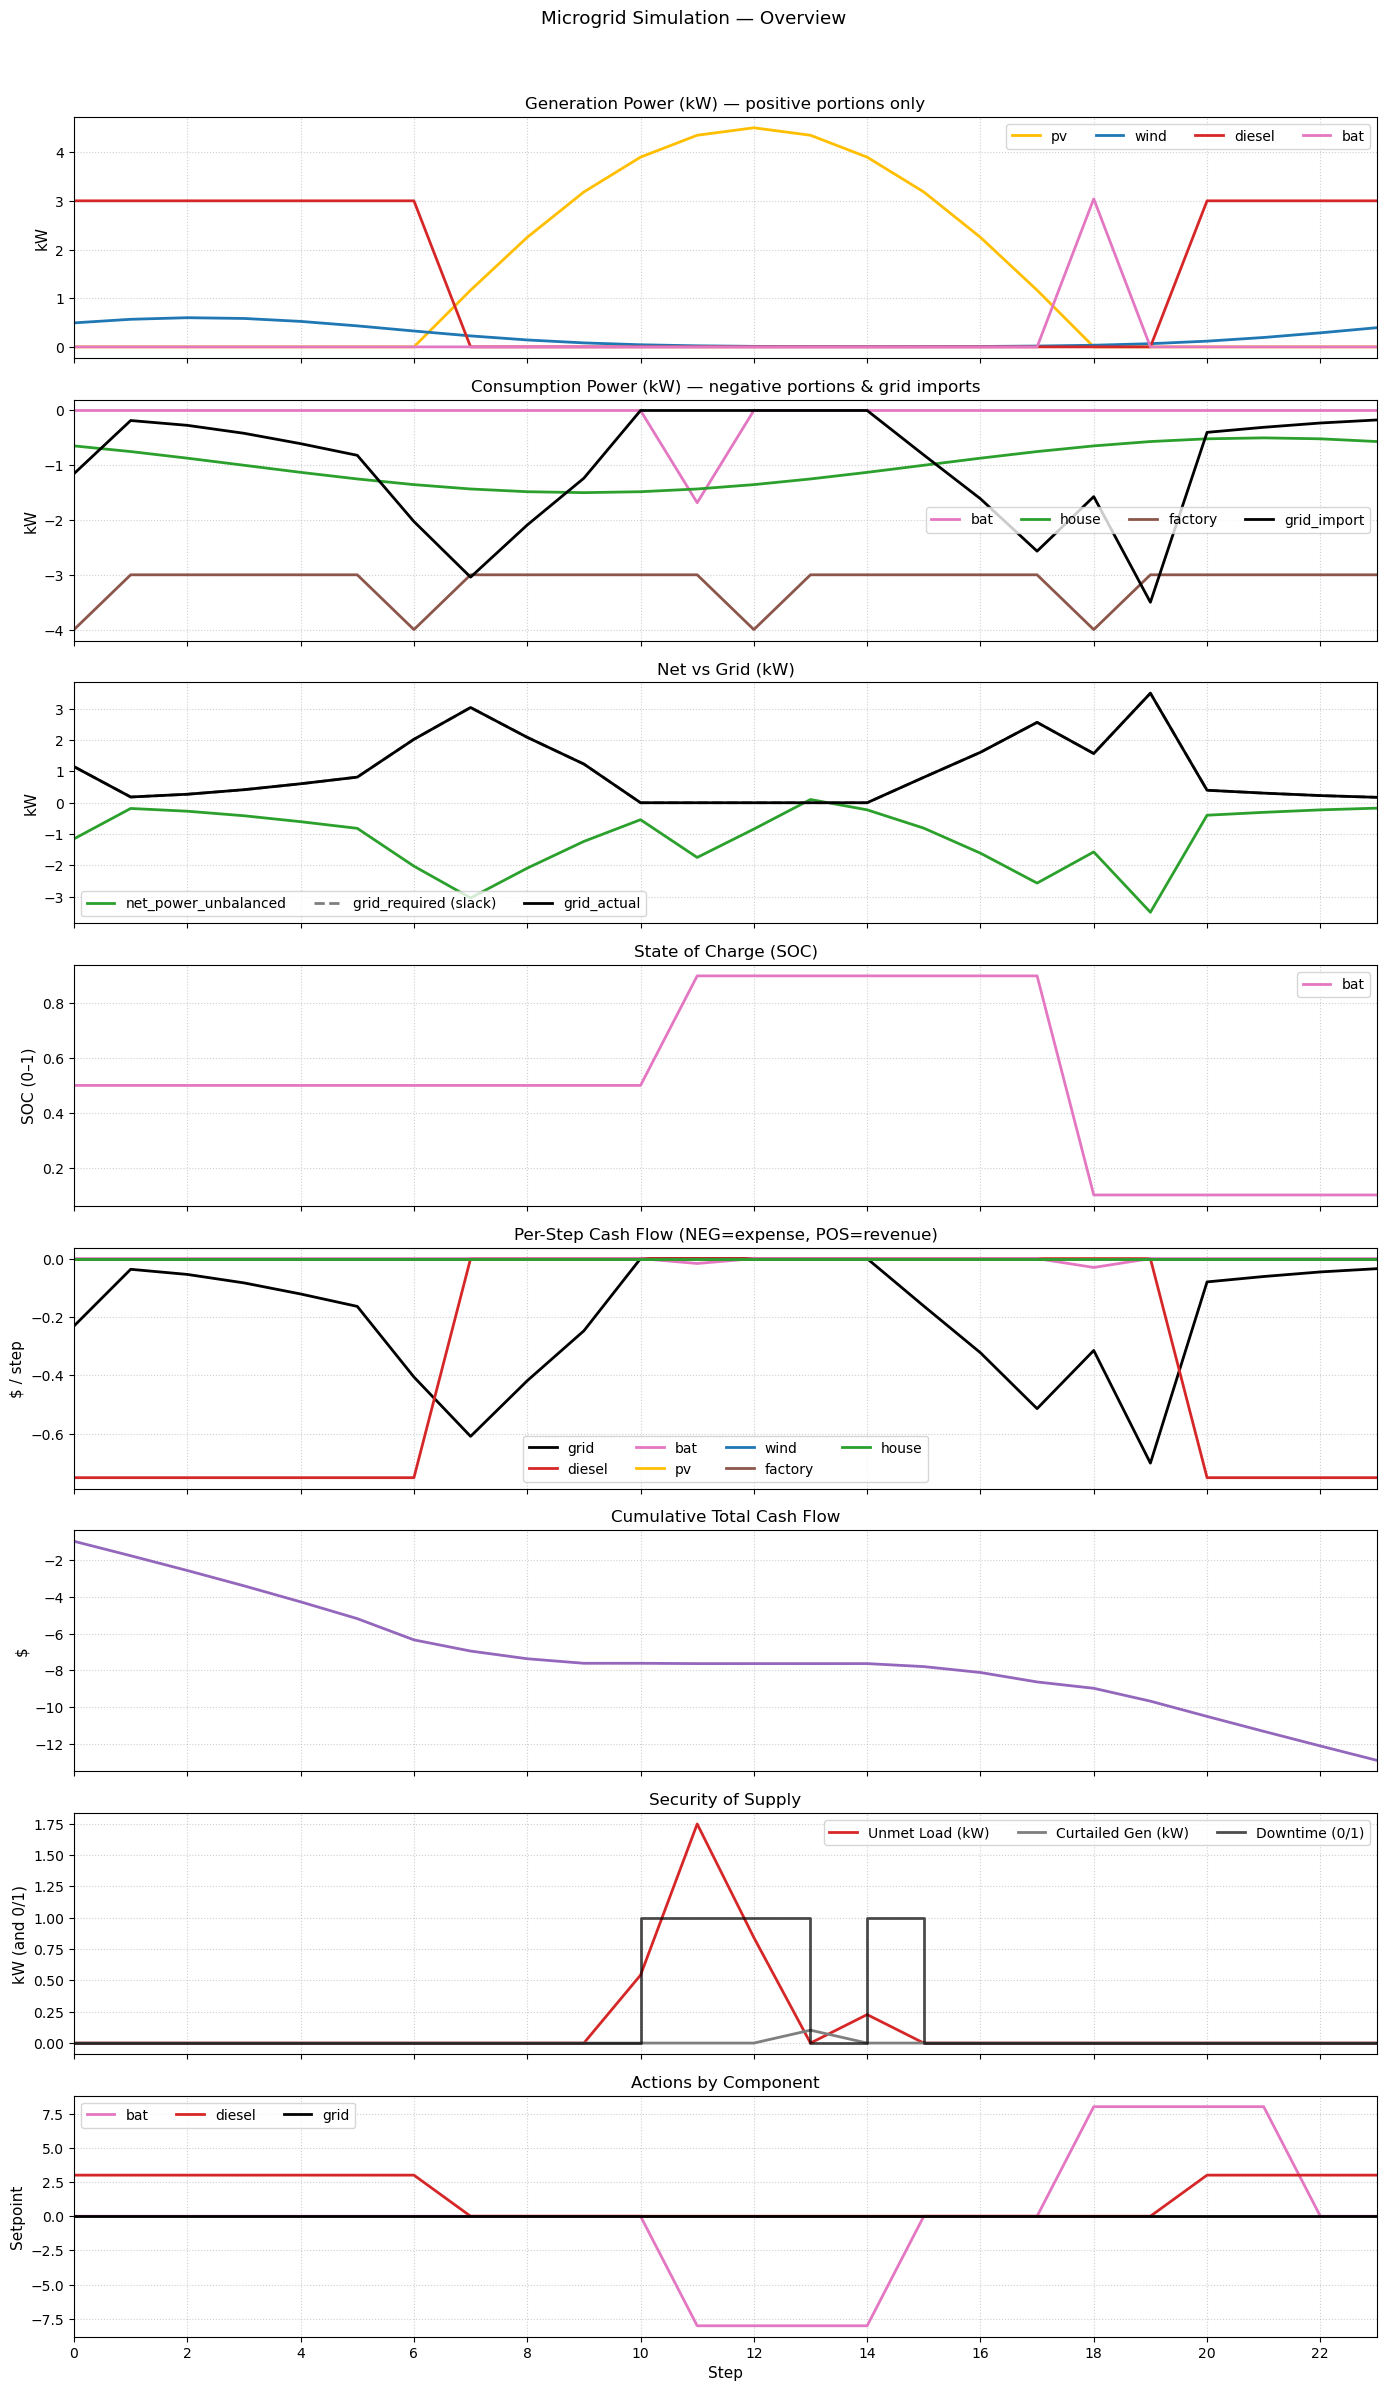

In [12]:
plot_simulation(df, actions=actions_list, xlim_auto=True,
                sim_name="grid_island_test", save=True)

## Simple Microgrid System

In [13]:
from microgrid_sim.system.microgrid import MicrogridSystem

system = MicrogridSystem(
    generators=[pv, wind, fossil],
    storage=[battery],
    loads=[house, factory],
    grid=grid,
)

summary = system.step(actions=actions_list[0], exogenous=exog_list[0])
print(summary)


{'gen_kw': 3.493056676893977, 'load_kw': -4.646446609406726, 'storage_kw': 0.0, 'grid_kw': 1.153389932512749, 'imbalance_kw': 0.0, 'unmet_kw': 0.0, 'curtailed_kw': 0.0, 'total_cost': -0.9806779865025498}
